# Artificial Neural Networks and Deep Learning

---

## Homework 2: Bio.log(y)

### Model 3: Residual U-Net + Attention Gates + Multi-scale (Dilated Convolutions in Bottleneck)

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.saving import register_keras_serializable


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data

In [3]:
# Load the compressed dataset
data = np.load("/kaggle/input/mydatasets-base/mars_datasets_base.npz")

# Extract the individual arrays
X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_our_test = data["X_our_test"]
y_our_test = data["y_our_test"]
X_test = data["X_test"]

# Print shapes to verify successful loading
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_our_test shape: {X_our_test.shape}")
print(f"y_our_test shape: {y_our_test.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1503, 64, 128, 1)
y_train shape: (1503, 64, 128)
X_val shape: (501, 64, 128, 1)
y_val shape: (501, 64, 128)
X_our_test shape: (501, 64, 128, 1)
y_our_test shape: (501, 64, 128)
X_test shape: (10022, 64, 128, 1)


## 🛠️ Train and Save the Model

In [4]:
input_shape = (64, 128, 1)
num_classes = len(np.unique(y_train))

In [5]:
# Number of training epochs
epochs = 200

# Batch size for training
batch_size = 32

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)

Epochs: 200
Batch Size: 32


In [6]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    label = np.asarray(label).squeeze()

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [7]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, num_classes, frequency=5):
        super().__init__()
        self.image = image
        self.label = label  # Assumiamo che `label` sia già un array NumPy
        self.num_classes = num_classes
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza solo ogni "frequency" epoche
            pred = self.model.predict(tf.expand_dims(self.image, axis=0), verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()

            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.image.squeeze(), cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(self.label, colormap)  # Rimosso `.numpy()`
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [8]:
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

    # Exclude the background class
    y_true = y_true[..., 1:]
    y_pred = y_pred[..., 1:]

    # Clip predictions
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

    # Focal loss
    cross_entropy = -y_true * tf.math.log(y_pred)
    weights = alpha * tf.math.pow(1 - y_pred, gamma)
    loss = weights * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

def dice_loss(y_true, y_pred, smooth=1e-6):

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)

    # Exclude the background class
    y_true = y_true[..., 1:]
    y_pred = y_pred[..., 1:]

    # Intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2])

    # Dice loss
    dice = 1 - (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

def combined_loss(y_true, y_pred, dice_weight=0.5, focal_weight=0.5):
    d_loss = dice_loss(y_true, y_pred)
    f_loss = focal_loss(y_true, y_pred)
    return focal_weight * f_loss + dice_weight * d_loss

In [9]:
def residual_block(x, filters, kernel_size=3, activation='relu', name=''):
    """A residual block with two convolutions, batch norm, and a skip connection."""
    skip = x
    # First conv
    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name+'conv1')(x)
    x = tfkl.BatchNormalization(name=name+'bn1')(x)
    x = tfkl.Activation(activation, name=name+'act1')(x)

    # Second conv
    x = tfkl.Conv2D(filters, kernel_size, padding='same', name=name+'conv2')(x)
    x = tfkl.BatchNormalization(name=name+'bn2')(x)

    # Adjust skip if necessary
    if skip.shape[-1] != filters:
        skip = tfkl.Conv2D(filters, 1, padding='same', name=name+'conv_skip')(skip)

    x = tfkl.Add(name=name+'add')([x, skip])
    x = tfkl.Activation(activation, name=name+'act2')(x)
    return x

In [10]:
def attention_gate(x, g, filters, name=''):
    """An attention gate that highlights relevant features from the skip connection x
    using the gating signal g from the decoder."""
    # Project x and g into a common space
    x_in = tfkl.Conv2D(filters, 1, padding='same', name=name+'x_conv')(x)
    g_in = tfkl.Conv2D(filters, 1, padding='same', name=name+'g_conv')(g)

    attn = tfkl.Activation('relu', name=name+'attn_relu')(tfkl.Add(name=name+'add')([x_in, g_in]))
    attn = tfkl.Conv2D(1, 1, padding='same', name=name+'attn_conv')(attn)
    attn = tfkl.Activation('sigmoid', name=name+'attn_sigmoid')(attn)

    x = tfkl.Multiply(name=name+'attn_mul')([x, attn])
    return x

In [11]:
def multi_scale_bottleneck(x, filters, activation='relu', name=''):
    """Multi-scale context with parallel dilated convolutions."""
    # Dilated convolutions with different rates
    x1 = tfkl.Conv2D(filters, 3, padding='same', dilation_rate=1, name=name+'dil1_conv')(x)
    x1 = tfkl.BatchNormalization(name=name+'dil1_bn')(x1)
    x1 = tfkl.Activation(activation, name=name+'dil1_act')(x1)

    x2 = tfkl.Conv2D(filters, 3, padding='same', dilation_rate=2, name=name+'dil2_conv')(x)
    x2 = tfkl.BatchNormalization(name=name+'dil2_bn')(x2)
    x2 = tfkl.Activation(activation, name=name+'dil2_act')(x2)

    x3 = tfkl.Conv2D(filters, 3, padding='same', dilation_rate=4, name=name+'dil3_conv')(x)
    x3 = tfkl.BatchNormalization(name=name+'dil3_bn')(x3)
    x3 = tfkl.Activation(activation, name=name+'dil3_act')(x3)

    # Concatenate the outputs
    x_cat = tfkl.Concatenate(name=name+'concat')([x1, x2, x3])

    # Compress back to the original number of filters
    x_out = tfkl.Conv2D(filters, 1, padding='same', name=name+'compress_conv')(x_cat)
    x_out = tfkl.BatchNormalization(name=name+'compress_bn')(x_out)
    x_out = tfkl.Activation(activation, name=name+'compress_act')(x_out)

    return x_out

In [12]:
def get_residual_attention_multiscale_unet_model(input_shape=(64,128,1), num_classes=5, activation='relu', seed=42):
    """
    Builds a Residual U-Net model with Attention Gates and Multi-Scale Context.
    """
    if seed is not None:
        tf.random.set_seed(seed)

    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    # Encoder
    f1 = residual_block(inputs, 64, name='enc1_')
    p1 = tfkl.MaxPooling2D((2,2), name='pool1')(f1)

    f2 = residual_block(p1, 128, name='enc2_')
    p2 = tfkl.MaxPooling2D((2,2), name='pool2')(f2)

    f3 = residual_block(p2, 256, name='enc3_')
    p3 = tfkl.MaxPooling2D((2,2), name='pool3')(f3)

    # Bottleneck with multi-scale context
    b = residual_block(p3, 512, name='bottleneck_pre_')
    b = multi_scale_bottleneck(b, 512, name='bottleneck_ms_')
    b = residual_block(b, 512, name='bottleneck_post_')

    # Decoder with Attention Gates
    # Level 3
    u1 = tfkl.UpSampling2D((2,2), name='up1')(b)
    attn3 = attention_gate(f3, u1, filters=256, name='attn3_')
    u1 = tfkl.Concatenate(name='concat3')([u1, attn3])
    u1 = residual_block(u1, 256, name='dec3_')

    # Level 2
    u2 = tfkl.UpSampling2D((2,2), name='up2')(u1)
    attn2 = attention_gate(f2, u2, filters=128, name='attn2_')
    u2 = tfkl.Concatenate(name='concat2')([u2, attn2])
    u2 = residual_block(u2, 128, name='dec2_')

    # Level 1
    u3 = tfkl.UpSampling2D((2,2), name='up3')(u2)
    attn1 = attention_gate(f1, u3, filters=64, name='attn1_')
    u3 = tfkl.Concatenate(name='concat1')([u3, attn1])
    u3 = residual_block(u3, 64, name='dec1_')

    # Output layer
    outputs = tfkl.Conv2D(num_classes, (1,1), activation='softmax', name='output_layer')(u3)

    # Final model
    model = tf.keras.Model(inputs, outputs, name='Residual_Attention_MultiScale_UNet')
    return model

Model: "Residual_Attention_MultiScale_UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_conv1        │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_bn1          │ (None, 64, 128, │       256 │ enc1_conv1[0]… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_act1         │ (None, 64, 128, │         0 │ enc1_bn1[0][0] │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_conv2        │ (None, 64, 128, │    36,928 │ enc1_act1[0][… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_bn2          │ (None, 64, 128, │       256 │ enc1_conv2[0]… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_conv_skip    │ (None, 64, 128, │       128 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_add (Add)    │ (None, 64, 128, │         0 │ enc1_bn2[0][0… │   -   │
│                   │ 64)             │           │ enc1_conv_ski… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_act2         │ (None, 64, 128, │         0 │ enc1_add[0][0] │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1             │ (None, 32, 64,  │         0 │ enc1_act2[0][… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_conv1        │ (None, 32, 64,  │    73,856 │ pool1[0][0]    │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_bn1          │ (None, 32, 64,  │       512 │ enc2_conv1[0]… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_act1         │ (None, 32, 64,  │         0 │ enc2_bn1[0][0] │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_conv2        │ (None, 32, 64,  │   147,584 │ enc2_act1[0][… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_bn2          │ (None, 32, 64,  │       512 │ enc2_conv2[0]… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_conv_skip    │ (None, 32, 64,  │     8,320 │ pool1[0][0]    │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_add (Add)    │ (None, 32, 64,  │         0 │ enc2_bn2[0][0… │   - 

 Total params: 21,082,504 (80.42 MB)

 Trainable params: 21,070,728 (80.38 MB)

 Non-trainable params: 11,776 (46.00 KB)

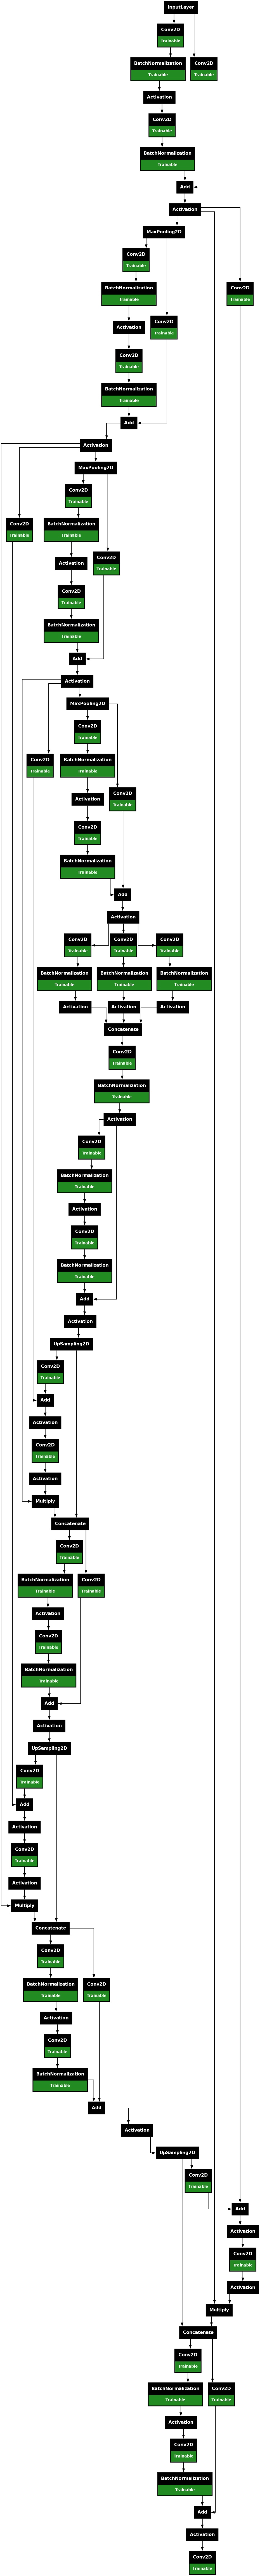

In [13]:
model = get_residual_attention_multiscale_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [14]:
model.compile(optimizer="adam",
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8),
              metrics=["accuracy",
                       MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])])

model.summary()

Model: "Residual_Attention_MultiScale_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv1 (Conv2D) │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_bn1            │ (None, 64, 128,   │        256 │ enc1_conv1[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_act1           │ (None, 64, 128,   │          0 │ enc1_bn1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv2 (Conv2D) │ (None, 64, 128,   │     36,928 │ enc1_act1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_bn2            │ (None, 64, 128,   │        256 │ enc1_conv2[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_conv_skip      │ (None, 64, 128,   │        128 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_add (Add)      │ (None, 64, 128,   │          0 │ enc1_bn2[0][0],   │
│                     │ 64)               │            │ enc1_conv_skip[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_act2           │ (None, 64, 128,   │          0 │ enc1_add[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 64,    │          0 │ enc1_act2[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv1 (Conv2D) │ (None, 32, 64,    │     73,856 │ pool1[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_bn1            │ (None, 32, 64,    │        512 │ enc2_conv1[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_act1           │ (None, 32, 64,    │          0 │ enc2_bn1[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv2 (Conv2D) │ (None, 32, 64,    │    147,584 │ enc2_act1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_bn2            │ (None, 32, 64,    │        512 │ enc2_conv2[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_conv_skip      │ (None, 32, 64,    │      8,320 │ pool1[0][0]       │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_add (Add)      │ (None, 32, 64,    │          0 │ enc2_bn2[0][0], 

 Total params: 21,082,504 (80.42 MB)

 Trainable params: 21,070,728 (80.38 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [15]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=20,
    restore_best_weights=True
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Select a specific image and mask from the dataset
sample_idx = 42
sample_image = X_train[sample_idx]
sample_mask = y_train[sample_idx]

# Initialize the VizCallback with the selected image and mask
viz_callback = VizCallback(
    image=sample_image,
    label=sample_mask,
    num_classes=num_classes,
    frequency=5
)

Epoch 1/200


I0000 00:00:1734105511.508572     118 service.cc:145] XLA service 0x7da0580024c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734105511.508635     118 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734105511.508639     118 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734105562.098665     118 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_9', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1734105562.129127     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.3296 - loss: 0.2817 - mean_iou: 0.1686

I0000 00:00:1734105633.438615     118 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_9', 16 bytes spill stores, 16 bytes spill loads



47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3307 - loss: 0.2809 - mean_iou: 0.1692   

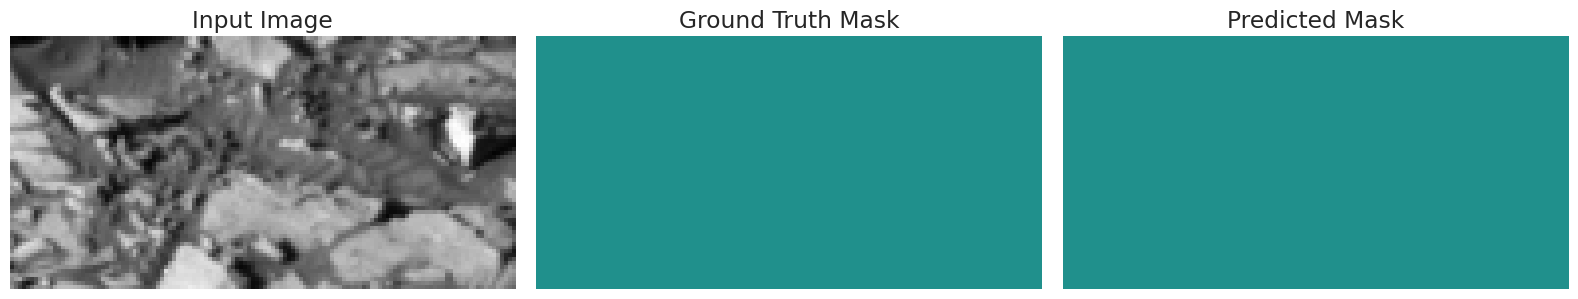

47/47 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.3316 - loss: 0.2802 - mean_iou: 0.1698 - val_accuracy: 0.2367 - val_loss: 1.8334 - val_mean_iou: 0.0778 - learning_rate: 0.0010
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.3954 - loss: 0.2243 - mean_iou: 0.2675 - val_accuracy: 0.2255 - val_loss: 0.3525 - val_mean_iou: 0.1032 - learning_rate: 0.0010
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 414ms/step - accuracy: 0.4583 - loss: 0.2169 - mean_iou: 0.3334 - val_accuracy: 0.1830 - val_loss: 0.5013 - val_mean_iou: 0.0601 - learning_rate: 0.0010
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 405ms/step - accuracy: 0.5211 - loss: 0.2079 - mean_iou: 0.4027 - val_accuracy: 0.1830 - val_loss: 0.5396 - val_mean_iou: 0.0601 - learning_rate: 0.0010
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 410ms/step - accuracy: 0.5791 - loss: 0.1999 - mean_iou: 0.4731 - val_accuracy: 0.1830 - val_loss: 0.6282 - val_mean_iou: 0.0601 - learning_rate: 0.0010
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━

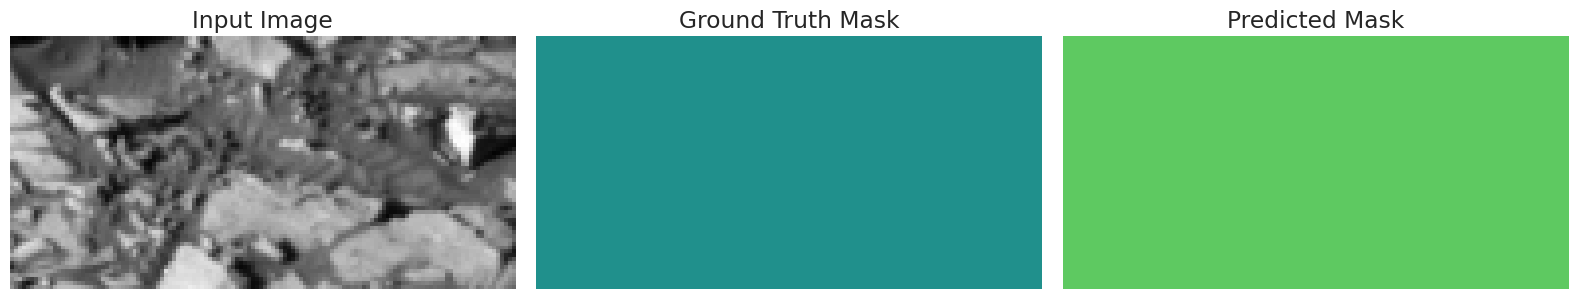

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.6116 - loss: 0.1923 - mean_iou: 0.5173 - val_accuracy: 0.1830 - val_loss: 0.6635 - val_mean_iou: 0.0601 - learning_rate: 0.0010
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.6088 - loss: 0.1907 - mean_iou: 0.5138
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.6092 - loss: 0.1907 - mean_iou: 0.5140 - val_accuracy: 0.2009 - val_loss: 0.5654 - val_mean_iou: 0.0747 - learning_rate: 0.0010
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 413ms/step - accuracy: 0.6219 - loss: 0.1876 - mean_iou: 0.5339 - val_accuracy: 0.1942 - val_loss: 0.6668 - val_mean_iou: 0.0693 - learning_rate: 5.0000e-04
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 413ms/step - accuracy: 0.6405 - loss: 0.1834 - mean_iou: 0.5605 - val_accuracy: 0.2387 - val_loss: 0.5368 - val_mean_iou: 0.1058 - learning_rate: 5.0000e-04
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 413ms/

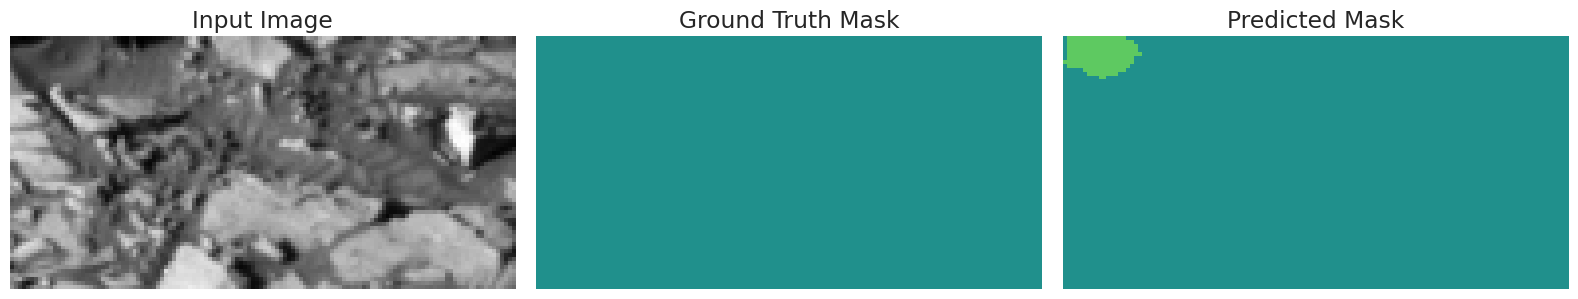

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 426ms/step - accuracy: 0.6515 - loss: 0.1799 - mean_iou: 0.5776 - val_accuracy: 0.4104 - val_loss: 0.3035 - val_mean_iou: 0.2785 - learning_rate: 5.0000e-04
Epoch 12/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.6549 - loss: 0.1776 - mean_iou: 0.5889 - val_accuracy: 0.4437 - val_loss: 0.2809 - val_mean_iou: 0.2938 - learning_rate: 5.0000e-04
Epoch 13/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.6481 - loss: 0.1798 - mean_iou: 0.5851 - val_accuracy: 0.5125 - val_loss: 0.2546 - val_mean_iou: 0.3654 - learning_rate: 5.0000e-04
Epoch 14/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.6514 - loss: 0.1775 - mean_iou: 0.6166 - val_accuracy: 0.3867 - val_loss: 0.3425 - val_mean_iou: 0.2482 - learning_rate: 5.0000e-04
Epoch 15/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.6439 - loss: 0.1812 - mean_iou: 0.5682 - val_accuracy: 0.5546 - val_loss: 0.2450 - val_mean_iou: 0.4322 - learning_rate: 5.0000e-04
Epoch 16

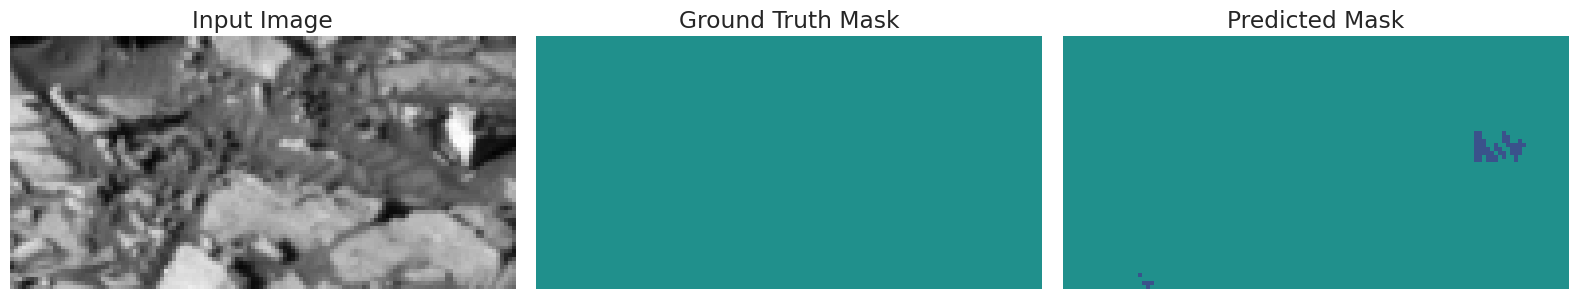

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - accuracy: 0.6597 - loss: 0.1770 - mean_iou: 0.6181 - val_accuracy: 0.6166 - val_loss: 0.1974 - val_mean_iou: 0.5072 - learning_rate: 5.0000e-04
Epoch 17/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 416ms/step - accuracy: 0.6680 - loss: 0.1733 - mean_iou: 0.6754 - val_accuracy: 0.6278 - val_loss: 0.1931 - val_mean_iou: 0.5232 - learning_rate: 5.0000e-04
Epoch 18/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.6766 - loss: 0.1713 - mean_iou: 0.6904 - val_accuracy: 0.6386 - val_loss: 0.1902 - val_mean_iou: 0.5396 - learning_rate: 5.0000e-04
Epoch 19/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.6786 - loss: 0.1697 - mean_iou: 0.7238 - val_accuracy: 0.6316 - val_loss: 0.1923 - val_mean_iou: 0.5269 - learning_rate: 5.0000e-04
Epoch 20/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.6734 - loss: 0.1716 - mean_iou: 0.7221 - val_accuracy: 0.6543 - val_loss: 0.1912 - val_mean_iou: 0.5651 - learning_rate: 5.0000e-04
Epoch 21

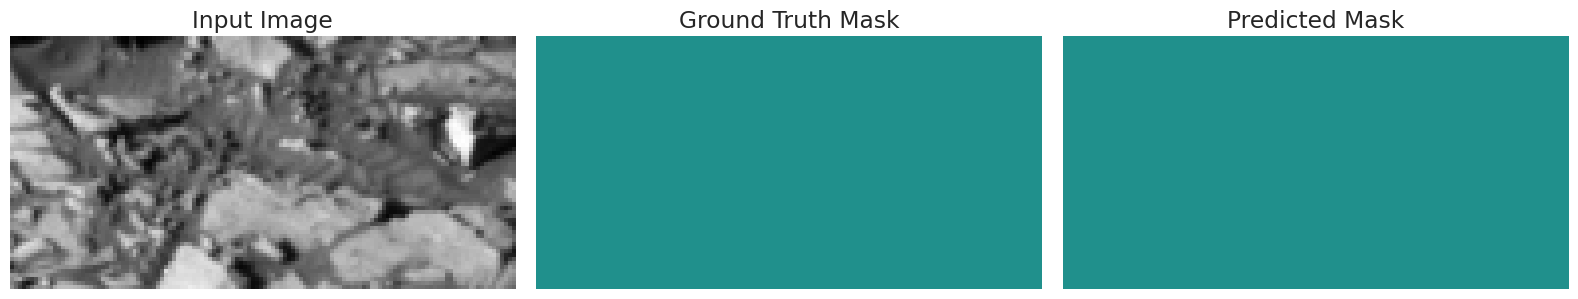

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.6650 - loss: 0.1738 - mean_iou: 0.6500 - val_accuracy: 0.6604 - val_loss: 0.1879 - val_mean_iou: 0.5676 - learning_rate: 5.0000e-04
Epoch 22/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.6760 - loss: 0.1704 - mean_iou: 0.6764 - val_accuracy: 0.6448 - val_loss: 0.1874 - val_mean_iou: 0.5673 - learning_rate: 5.0000e-04
Epoch 23/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step - accuracy: 0.6802 - loss: 0.1689 - mean_iou: 0.7458 - val_accuracy: 0.6499 - val_loss: 0.1871 - val_mean_iou: 0.5612 - learning_rate: 5.0000e-04
Epoch 24/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.6958 - loss: 0.1635 - mean_iou: 0.7793 - val_accuracy: 0.6451 - val_loss: 0.1955 - val_mean_iou: 0.5492 - learning_rate: 5.0000e-04
Epoch 28/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.7014 - loss: 0.1615 - mean_iou: 0.7492 - val_accuracy: 0.6251 - val_loss: 0.2033 - val_mean_iou: 0.5175 - learning_rate: 5.0000e-04
Epoch 29

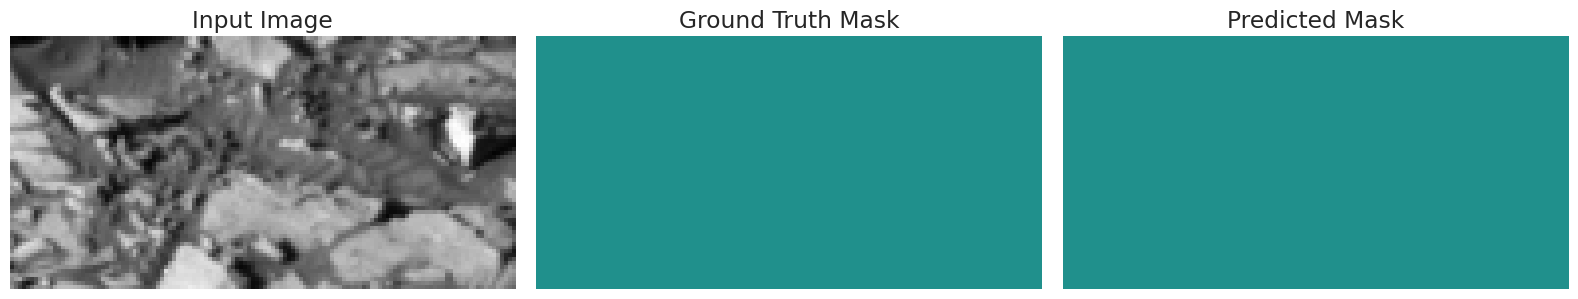

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - accuracy: 0.7150 - loss: 0.1572 - mean_iou: 0.8600 - val_accuracy: 0.6783 - val_loss: 0.1861 - val_mean_iou: 0.6006 - learning_rate: 2.5000e-04
Epoch 32/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7229 - loss: 0.1548 - mean_iou: 0.9116 - val_accuracy: 0.6795 - val_loss: 0.1879 - val_mean_iou: 0.6026 - learning_rate: 2.5000e-04
Epoch 33/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.7243 - loss: 0.1523 - mean_iou: 0.9122 - val_accuracy: 0.6737 - val_loss: 0.1936 - val_mean_iou: 0.5932 - learning_rate: 2.5000e-04
Epoch 34/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.7050 - loss: 0.1361 - mean_iou: 0.7865
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.7047 - loss: 0.1363 - mean_iou: 0.7847 - val_accuracy: 0.4841 - val_loss: 0.6394 - val_mean_iou: 0.3330 - learning_rate: 2.5000e-04
Epoch 35/200
47/47 ━━━━━━━━━━━━━━━━━━━

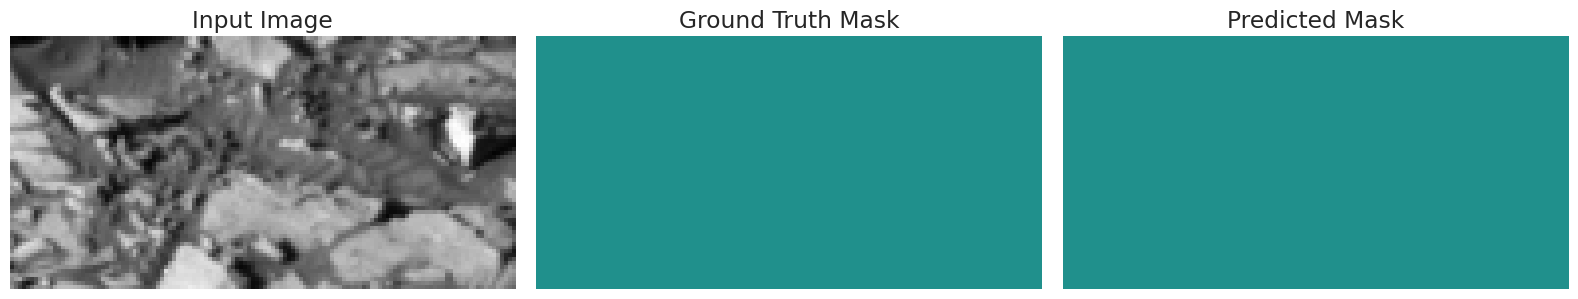

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 424ms/step - accuracy: 0.7007 - loss: 0.0983 - mean_iou: 0.6616 - val_accuracy: 0.6749 - val_loss: 0.1285 - val_mean_iou: 0.5937 - learning_rate: 1.2500e-04
Epoch 37/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 413ms/step - accuracy: 0.7128 - loss: 0.0847 - mean_iou: 0.6834 - val_accuracy: 0.6730 - val_loss: 0.1328 - val_mean_iou: 0.5915 - learning_rate: 1.2500e-04
Epoch 38/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 413ms/step - accuracy: 0.7174 - loss: 0.0793 - mean_iou: 0.6925 - val_accuracy: 0.6788 - val_loss: 0.1342 - val_mean_iou: 0.6021 - learning_rate: 1.2500e-04
Epoch 39/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 413ms/step - accuracy: 0.7164 - loss: 0.0774 - mean_iou: 0.6908 - val_accuracy: 0.6782 - val_loss: 0.1305 - val_mean_iou: 0.6005 - learning_rate: 1.2500e-04
Epoch 40/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 416ms/step - accuracy: 0.7235 - loss: 0.0744 - mean_iou: 0.7042 - val_accuracy: 0.6840 - val_loss: 0.1404 - val_mean_iou: 0.6121 - learning_rate: 1.2500e-04
Epoch 41

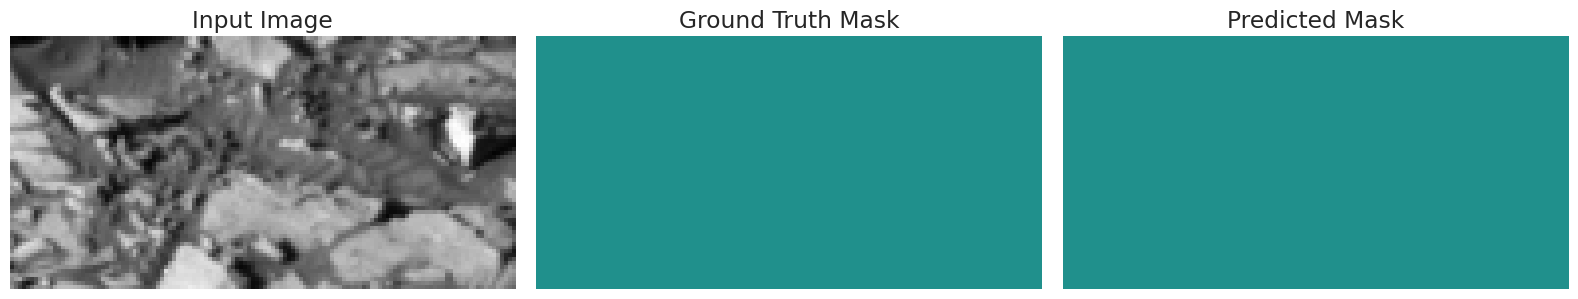

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 427ms/step - accuracy: 0.7256 - loss: 0.0704 - mean_iou: 0.7085 - val_accuracy: 0.6777 - val_loss: 0.1486 - val_mean_iou: 0.6002 - learning_rate: 1.2500e-04
Epoch 42/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.7258 - loss: 0.0777 - mean_iou: 0.7084 - val_accuracy: 0.6820 - val_loss: 0.1393 - val_mean_iou: 0.6061 - learning_rate: 6.2500e-05
Epoch 43/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7303 - loss: 0.0670 - mean_iou: 0.7171 - val_accuracy: 0.6849 - val_loss: 0.1513 - val_mean_iou: 0.6108 - learning_rate: 6.2500e-05
Epoch 44/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7319 - loss: 0.0655 - mean_iou: 0.7205 - val_accuracy: 0.6822 - val_loss: 0.1611 - val_mean_iou: 0.6064 - learning_rate: 6.2500e-05
Epoch 45/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7342 - loss: 0.0641 - mean_iou: 0.7251 - val_accuracy: 0.6840 - val_loss: 0.1569 - val_mean_iou: 0.6106 - learning_rate: 6.2500e-05
Epoch 46

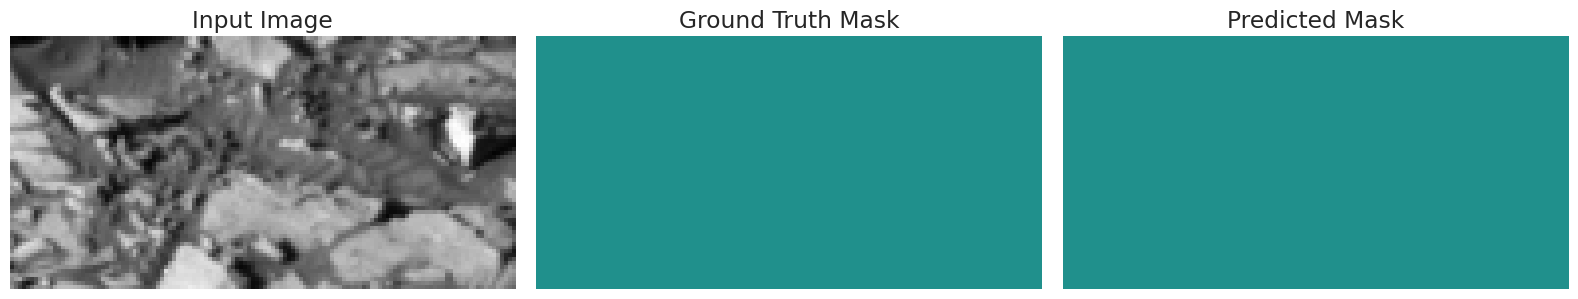

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.7337 - loss: 0.0633 - mean_iou: 0.7242 - val_accuracy: 0.6870 - val_loss: 0.1551 - val_mean_iou: 0.6159 - learning_rate: 6.2500e-05
Epoch 47/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7353 - loss: 0.0621 - mean_iou: 0.7274 - val_accuracy: 0.6889 - val_loss: 0.1527 - val_mean_iou: 0.6193 - learning_rate: 3.1250e-05
Epoch 48/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.7393 - loss: 0.0605 - mean_iou: 0.7352 - val_accuracy: 0.6879 - val_loss: 0.1600 - val_mean_iou: 0.6177 - learning_rate: 3.1250e-05
Epoch 49/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.7397 - loss: 0.0600 - mean_iou: 0.7362 - val_accuracy: 0.6880 - val_loss: 0.1627 - val_mean_iou: 0.6176 - learning_rate: 3.1250e-05
Epoch 50/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.7402 - loss: 0.0596 - mean_iou: 0.7372 - val_accuracy: 0.6879 - val_loss: 0.1653 - val_mean_iou: 0.6174 - learning_rate: 3.1250e-05
Epoch 51

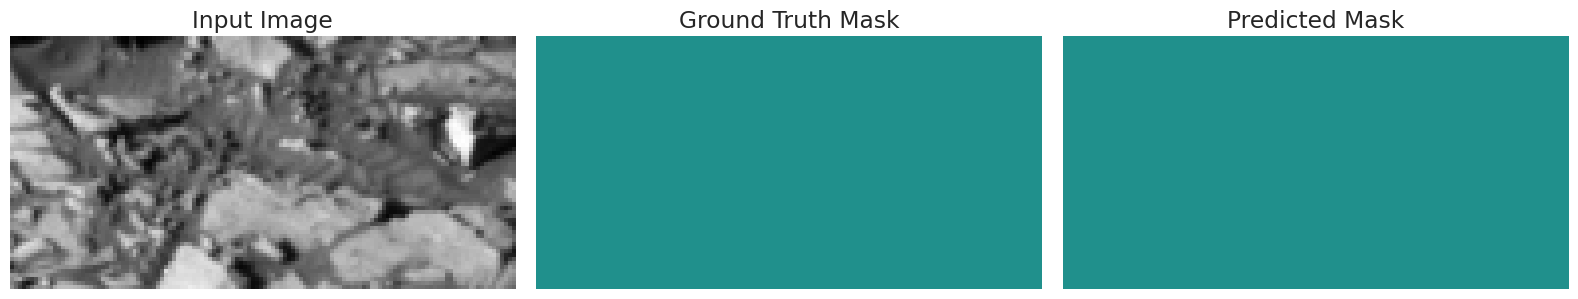

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7408 - loss: 0.0593 - mean_iou: 0.7384 - val_accuracy: 0.6888 - val_loss: 0.1658 - val_mean_iou: 0.6186 - learning_rate: 3.1250e-05
Epoch 52/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.7410 - loss: 0.0590 - mean_iou: 0.7389 - val_accuracy: 0.6889 - val_loss: 0.1645 - val_mean_iou: 0.6191 - learning_rate: 1.5625e-05
Epoch 53/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 419ms/step - accuracy: 0.7413 - loss: 0.0588 - mean_iou: 0.7394 - val_accuracy: 0.6893 - val_loss: 0.1657 - val_mean_iou: 0.6196 - learning_rate: 1.5625e-05
Epoch 54/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7414 - loss: 0.0587 - mean_iou: 0.7397 - val_accuracy: 0.6895 - val_loss: 0.1669 - val_mean_iou: 0.6200 - learning_rate: 1.5625e-05
Epoch 55/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.7415 - loss: 0.0586 - mean_iou: 0.7399 - val_accuracy: 0.6895 - val_loss: 0.1675 - val_mean_iou: 0.6200 - learning_rate: 1.5625e-05
Epoch 56

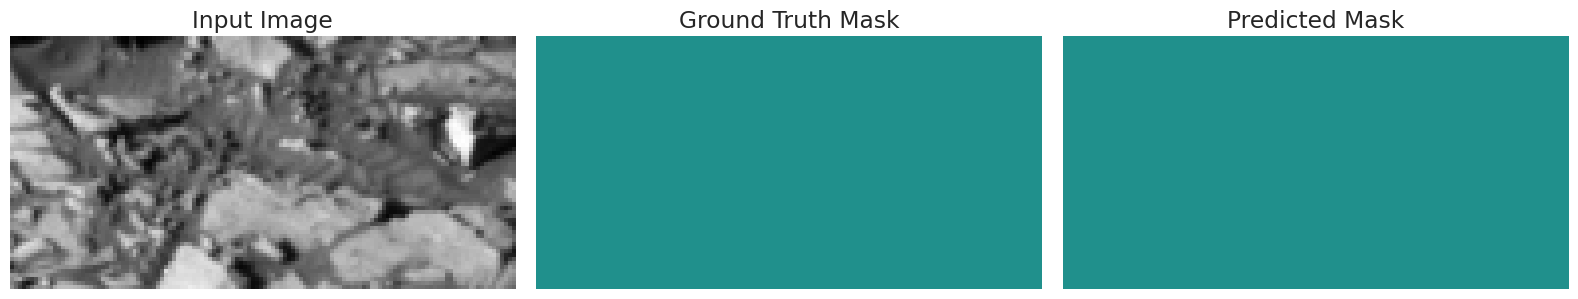

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.7416 - loss: 0.0585 - mean_iou: 0.7401 - val_accuracy: 0.6894 - val_loss: 0.1683 - val_mean_iou: 0.6199 - learning_rate: 1.5625e-05
Epoch 57/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.7418 - loss: 0.0584 - mean_iou: 0.7404 - val_accuracy: 0.6894 - val_loss: 0.1687 - val_mean_iou: 0.6200 - learning_rate: 7.8125e-06
Epoch 58/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 416ms/step - accuracy: 0.7418 - loss: 0.0584 - mean_iou: 0.7405 - val_accuracy: 0.6893 - val_loss: 0.1691 - val_mean_iou: 0.6199 - learning_rate: 7.8125e-06
Epoch 59/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.7419 - loss: 0.0583 - mean_iou: 0.7406 - val_accuracy: 0.6892 - val_loss: 0.1698 - val_mean_iou: 0.6197 - learning_rate: 7.8125e-06
Epoch 60/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.7419 - loss: 0.0583 - mean_iou: 0.7407 - val_accuracy: 0.6891 - val_loss: 0.1705 - val_mean_iou: 0.6195 - learning_rate: 7.8125e-06
Epoch 61

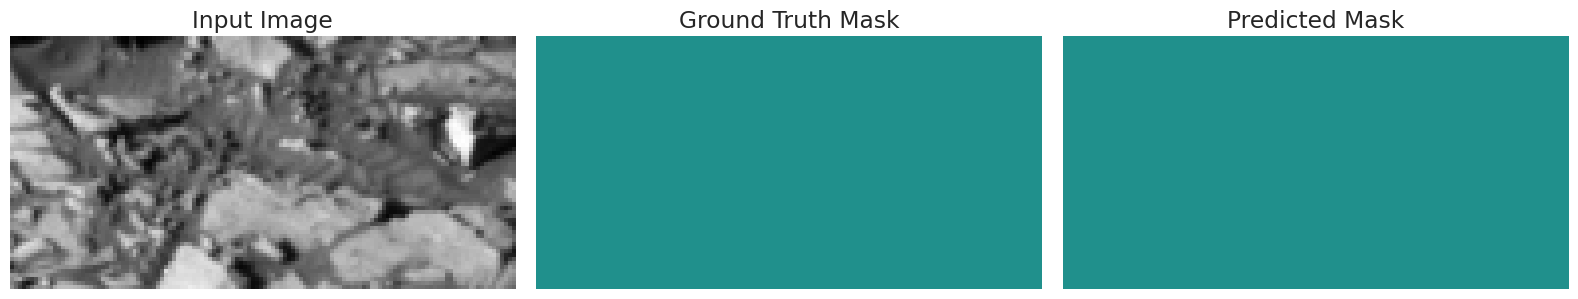

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 425ms/step - accuracy: 0.7420 - loss: 0.0582 - mean_iou: 0.7408 - val_accuracy: 0.6891 - val_loss: 0.1710 - val_mean_iou: 0.6194 - learning_rate: 7.8125e-06
Epoch 62/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.7420 - loss: 0.0582 - mean_iou: 0.7409 - val_accuracy: 0.6891 - val_loss: 0.1712 - val_mean_iou: 0.6195 - learning_rate: 3.9063e-06
Epoch 63/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.7420 - loss: 0.0582 - mean_iou: 0.7409 - val_accuracy: 0.6891 - val_loss: 0.1714 - val_mean_iou: 0.6195 - learning_rate: 3.9063e-06
Epoch 64/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7421 - loss: 0.0582 - mean_iou: 0.7410 - val_accuracy: 0.6891 - val_loss: 0.1716 - val_mean_iou: 0.6195 - learning_rate: 3.9063e-06
Epoch 65/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - accuracy: 0.7421 - loss: 0.0581 - mean_iou: 0.7410 - val_accuracy: 0.6891 - val_loss: 0.1718 - val_mean_iou: 0.6194 - learning_rate: 3.9063e-06
Epoch 66

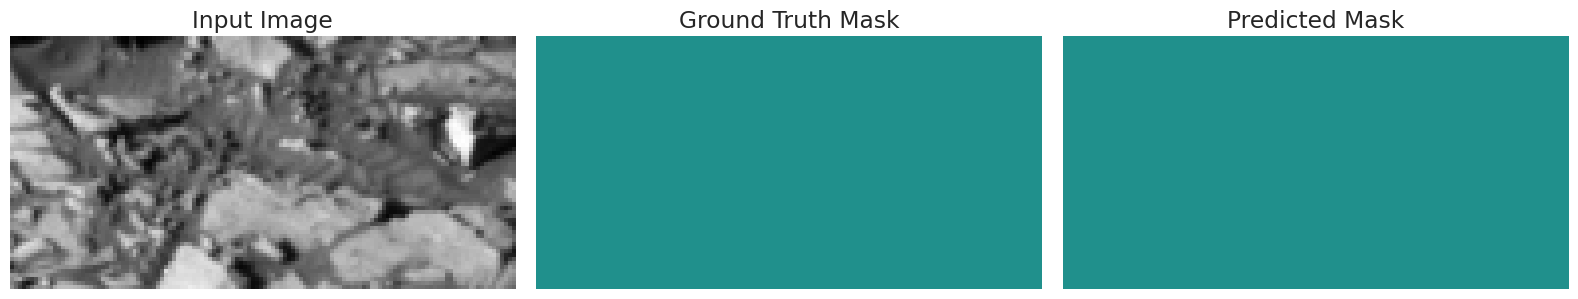

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - accuracy: 0.7421 - loss: 0.0581 - mean_iou: 0.7411 - val_accuracy: 0.6891 - val_loss: 0.1720 - val_mean_iou: 0.6194 - learning_rate: 3.9063e-06
Epoch 67/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.7421 - loss: 0.0581 - mean_iou: 0.7411 - val_accuracy: 0.6891 - val_loss: 0.1720 - val_mean_iou: 0.6194 - learning_rate: 1.9531e-06
Epoch 68/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.7421 - loss: 0.0581 - mean_iou: 0.7412 - val_accuracy: 0.6891 - val_loss: 0.1721 - val_mean_iou: 0.6194 - learning_rate: 1.9531e-06
Epoch 69/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7422 - loss: 0.0581 - mean_iou: 0.7412 - val_accuracy: 0.6891 - val_loss: 0.1722 - val_mean_iou: 0.6194 - learning_rate: 1.9531e-06
Epoch 70/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7422 - loss: 0.0581 - mean_iou: 0.7412 - val_accuracy: 0.6891 - val_loss: 0.1723 - val_mean_iou: 0.6194 - learning_rate: 1.9531e-06
Epoch 71

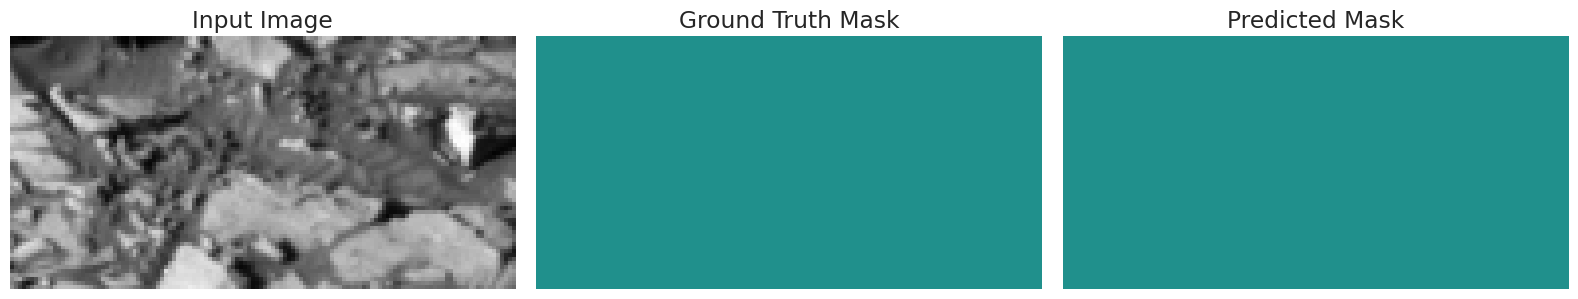

47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7422 - loss: 0.0581 - mean_iou: 0.7412 - val_accuracy: 0.6891 - val_loss: 0.1724 - val_mean_iou: 0.6194 - learning_rate: 1.9531e-06
Epoch 72/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.7422 - loss: 0.0580 - mean_iou: 0.7413 - val_accuracy: 0.6891 - val_loss: 0.1724 - val_mean_iou: 0.6194 - learning_rate: 1.0000e-06
Epoch 73/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7422 - loss: 0.0580 - mean_iou: 0.7413 - val_accuracy: 0.6891 - val_loss: 0.1725 - val_mean_iou: 0.6194 - learning_rate: 1.0000e-06
Epoch 74/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.7422 - loss: 0.0580 - mean_iou: 0.7413 - val_accuracy: 0.6891 - val_loss: 0.1725 - val_mean_iou: 0.6194 - learning_rate: 1.0000e-06


In [16]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, viz_callback],
    verbose=1
).history

In [17]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_3_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 62.0%


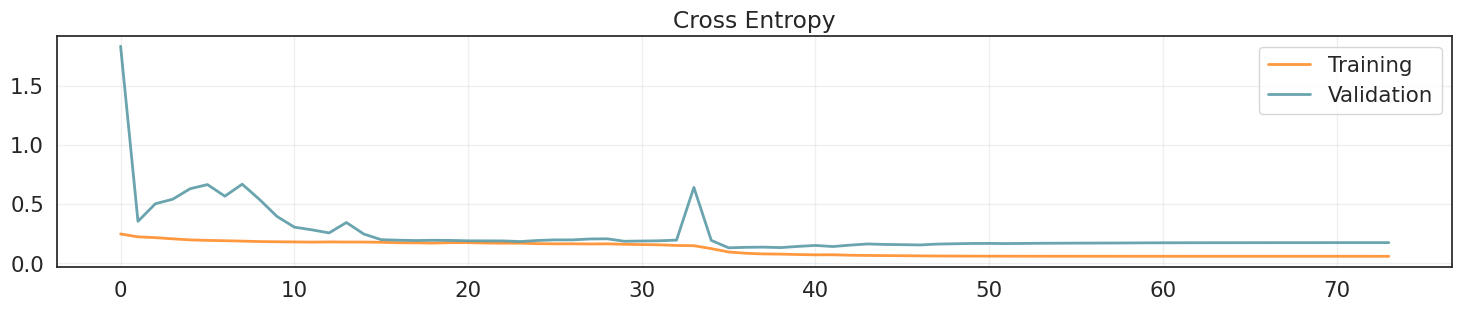

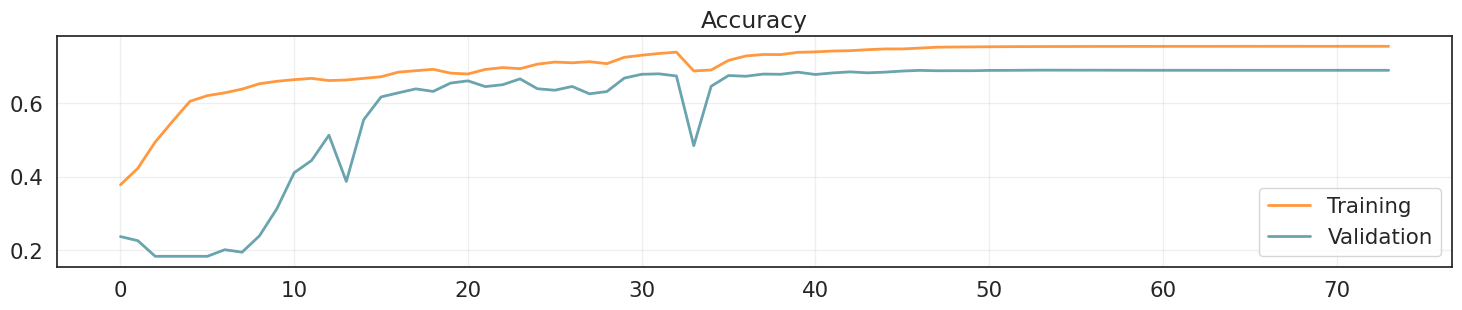

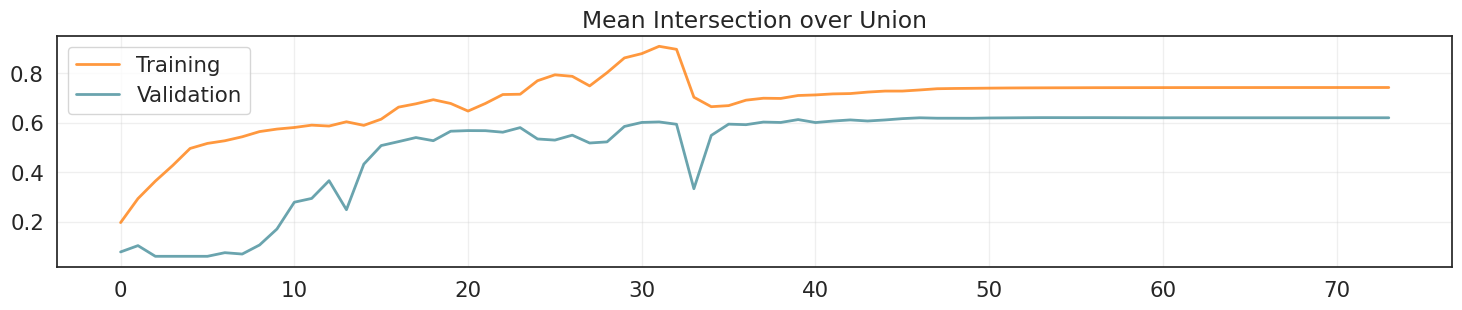

In [18]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model - Make Inference

In [22]:
# path
model_path = "/kaggle/working/UNet_3_62.0.keras"

# Load the model
model = tf.keras.models.load_model(model_path, compile=False)
print("Model loaded successfully.")

Model loaded successfully.


In [23]:
model.compile(optimizer="adam",
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8),
              metrics=["accuracy",
                       MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])])

In [24]:
test_loss, test_accuracy, test_mean_iou = model.evaluate(X_our_test, y_our_test, verbose=1)
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}\nMean Over Union: {test_mean_iou}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.6655 - loss: 0.1756 - mean_iou: 0.6154
Loss: 0.15773554146289825
Accuracy: 0.6774673461914062
Mean Over Union: 0.6219228506088257


In [25]:
def calculate_class_iou(y_true, y_pred, num_classes):
    class_iou = {}

    for class_idx in range(num_classes):
        # Crea una maschera binaria per la classe
        true_mask = (y_true == class_idx).astype(int)
        pred_mask = (y_pred == class_idx).astype(int)

        # Calcola l'intersezione e l'unione
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Calcola IoU, evitando la divisione per zero
        iou = intersection / union if union > 0 else 0.0
        class_iou[class_idx] = iou

    return class_iou

In [26]:
# Compute the prediction
y_pred = model.predict(X_our_test, batch_size=10)
y_pred_labels = tf.math.argmax(y_pred, axis=-1).numpy()

# Compute IoU per class
iou_per_class = calculate_class_iou(y_our_test, y_pred_labels, num_classes)

# Print the results
for class_idx, iou in iou_per_class.items():
    print(f"Class {class_idx}: IoU = {round(iou, 4)}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step
Class 0: IoU = 0.0
Class 1: IoU = 0.7104
Class 2: IoU = 0.5468
Class 3: IoU = 0.6351
Class 4: IoU = 0.0


In [27]:
def calculate_metrics_per_class(y_true, y_pred, num_classes):
    metrics = {}

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        true_binary = (y_true == class_idx).flatten()
        pred_binary = (y_pred == class_idx).flatten()

        # Compute precision, recall, and F1-score
        precision = precision_score(true_binary, pred_binary, zero_division=0)
        recall = recall_score(true_binary, pred_binary, zero_division=0)
        f1 = f1_score(true_binary, pred_binary, zero_division=0)

        # Store the metrics for the current class
        metrics[class_idx] = {
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }

    return metrics

In [28]:
# Compute metrics for each class
metrics_per_class = calculate_metrics_per_class(y_our_test, y_pred_labels, num_classes)

# Print the results for each class
for class_idx, metrics in metrics_per_class.items():
    print(f"Class {class_idx}:")
    print(f"  Precision = {round(metrics['Precision'], 4)}")
    print(f"  Recall = {round(metrics['Recall'], 4)}")
    print(f"  F1-score = {round(metrics['F1-score'], 4)}")

Class 0:
  Precision = 0.0
  Recall = 0.0
  F1-score = 0.0
Class 1:
  Precision = 0.7534
  Recall = 0.9255
  F1-score = 0.8307
Class 2:
  Precision = 0.5889
  Recall = 0.8843
  F1-score = 0.707
Class 3:
  Precision = 0.6753
  Recall = 0.9144
  F1-score = 0.7769
Class 4:
  Precision = 0.0
  Recall = 0.0
  F1-score = 0.0


## 📊 Prepare Your Submission


In [29]:
# Percorso del file del modello
model_path = "/kaggle/working/UNet_3_62.0.keras"

# Carica il modello
model = tf.keras.models.load_model(model_path, compile=False)
print("Model loaded successfully.")

Model loaded successfully.


In [30]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 47s 145ms/step
Predictions shape: (10022, 64, 128)


In [31]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [32]:
# Create and save the CSV submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)  # Convert predictions to DataFrame
submission_df.to_csv(f"/kaggle/working/{submission_filename}", index=False)

print(f"Submission file saved: {submission_filename}")

Submission file saved: submission_UNet_3_62.0.csv
